# Train_logistic_regression_model_using_mlflow

**Background:**

**Purpose:**

**Methods:**
>1. Introduction
>2. Inits

**Conclusions:**
* Verify that the best models are not just predicting 1's for everyone
* The model that balanced performance, feature count, and class 0 performance had paramters:
   * log10_C between [-0.88889, -0.66667]
   * lower_quantile_removed_CoV between [0.5, 0.9]
* Increaing the # of max_iterations from 1,000 to 10,000 didn't improve the performance

# Inits

## Imports

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context='notebook', font_scale=1.5)

import logging
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import glob

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.linear_model import LogisticRegression

import mlflow

# Load my own custom module
import data_loading
import model_funcs
import constants

import imblearn
import joblib

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import sklearn.metrics as skl_metrics

## Definitions

In [20]:
experiment_base_path = f'{constants.base_dir}/mlruns/'
mlflow.set_tracking_uri(f'file://{experiment_base_path}')


test_param_dict = {'C': 1e-1,
                 'max_iter': 30,
                 'solver': 'saga',
                 'class_weight': None,
                 'lower_quantile_removed_CoV': 0,
                  'use_smote': True}

## Funcs

### Run MLFlow Experiment V5

In [57]:
def run_mlflow_exp_v9(X_cv, X_test, y_cv, y_test, curr_param_index, curr_params_dict):

    # Set the experiment name
    mlflow.set_tracking_uri(f'file://{experiment_base_path}')
    #mlflow.set_experiment('V4-l1-Logistic_Regression_Exp')
    
    # Start a mlflow run
    with mlflow.start_run():
        mlflow.set_tag('description', 
        """
        In this run, I added a parameter that controls what lower quantile of the data is removed based on CoV.
        """)
        
        # Define the model
        log_regr_clf = LogisticRegression(penalty='l1',
                                          C=curr_params_dict['C'],
                                          class_weight=curr_params_dict['class_weight'],
                                          random_state=110,
                                          solver=curr_params_dict['solver'],
                                          max_iter=curr_params_dict['max_iter'],
                                          verbose=0,
                                          n_jobs=None,
                                          l1_ratio=None)
                
        # Remove the lowest quartile of genes based on CoV
        # Calculate the CoV
        gene_expr_cov_list = 100 * (X_cv.std(ddof=1, axis=0) / X_cv.mean(axis=0))
        
        # Calculate the qth quantile
        min_cov_threshold = np.quantile(gene_expr_cov_list, q=[curr_params_dict['lower_quantile_removed_CoV']])[0]
        
        # Get a list of genes to removed
        low_cov_gene_list = gene_expr_cov_list.loc[(gene_expr_cov_list < min_cov_threshold)].index.tolist()
        
        # Remove the lowest quantile(s) of genes based on CoV
        X_cv.drop(low_cov_gene_list, axis=1, inplace=True)
        X_test.drop(low_cov_gene_list, axis=1, inplace=True)
        
        # Run custom CV so I can train on over-sampled data but test on original data
        kfold_obj = KFold(n_splits=5, shuffle=True)

        cv_train_accuracy_list = []
        cv_test_accuracy_list = []
        cv_test_accuracy_of_0_cases_list = []
        
        for curr_train_iloc_list, curr_test_iloc_list in kfold_obj.split(X=X_cv, y=y_cv):

            # Create current fold train data
            curr_fold_X_train = X_cv.iloc[curr_train_iloc_list, ]
            curr_fold_y_train = y_cv.iloc[curr_train_iloc_list, ]
            
            # Create current fold train data
            curr_fold_X_test = X_cv.iloc[curr_test_iloc_list, ]
            curr_fold_y_test = y_cv.iloc[curr_test_iloc_list, ]

            # Run SMOTE on the X,y data
            smote_obj = imblearn.over_sampling.SMOTE(sampling_strategy='auto', 
                                                     random_state=110, 
                                                     k_neighbors=5, 
                                                     n_jobs=None)

            curr_fold_X_train_smote, curr_fold_y_train_smote = smote_obj.fit_sample(curr_fold_X_train, curr_fold_y_train)

            # Train the model on the over-sampled (SMOTE) training data for this k-fold
            log_regr_clf.fit(curr_fold_X_train_smote, curr_fold_y_train_smote)

            # Calculate accuracy on non-oversampled data
            curr_fold_y_train_pred = pd.Series(log_regr_clf.predict(curr_fold_X_train), index=curr_fold_y_train.index)
            curr_fold_y_test_pred = pd.Series(log_regr_clf.predict(curr_fold_X_test), index=curr_fold_y_test.index)

            # Calculate result metrics like accuracy
            cv_train_accuracy_list.append((curr_fold_y_train_pred == curr_fold_y_train).mean())
            cv_test_accuracy_list.append((curr_fold_y_test_pred == curr_fold_y_test).mean())
            
            # Calculate the test accuracy of target=0 cases
            cv_test_accuracy_of_0_cases_list = np.mean(curr_fold_y_test_pred[(curr_fold_y_test == 0)] == 0)
            
        
        # Run SMOTE on the full X_cv,y_cv data
        smote_obj = imblearn.over_sampling.SMOTE(sampling_strategy='auto', 
                                                 random_state=110, 
                                                 k_neighbors=5, 
                                                 n_jobs=None)
        X_cv_smote, y_cv_smote = smote_obj.fit_sample(X_cv, y_cv)
        
        # Train the model
        log_regr_clf.fit(X_cv_smote, y_cv_smote)
        
        # Calculate test accuracy
        y_test_pred = pd.Series(log_regr_clf.predict(X_test), index=y_test.index)
        test_accuracy = (y_test_pred == y_test).mean()
        
        # Calculate the false positive rate and true positive rate
        train_auc = skl_metrics.roc_auc_score(y_true=y_cv, 
                                             y_score=log_regr_clf.predict_proba(X_cv)[:, 1])
        test_auc = skl_metrics.roc_auc_score(y_true=y_test, 
                                             y_score=log_regr_clf.predict_proba(X_test)[:, 1])
        
        # Log parameters
        mlflow.log_param("log10_C", np.log10(curr_params_dict['C']))
        mlflow.log_param("log10_max_iter", np.log10(curr_params_dict['max_iter']))
        mlflow.log_param("solver", curr_params_dict['solver'])
        mlflow.log_param("class_weight", curr_params_dict['class_weight'])
        mlflow.log_param("lower_quantile_removed_CoV", curr_params_dict['lower_quantile_removed_CoV'])
        
        # Log CV metrics
        mlflow.log_metric("cv_training_accuracy", np.mean(cv_train_accuracy_list))
        mlflow.log_metric("cv_test_accuracy", np.mean(cv_test_accuracy_list))
        mlflow.log_metric("cv_test_0_class_accuracy", np.mean(cv_test_accuracy_of_0_cases_list))
        
        # Log test metrics
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("train_auc", train_auc)
        mlflow.log_metric("test_auc", test_auc)

        # Log count of non-zero features
        mlflow.log_metric("count_non_zero_features", np.sum(log_regr_clf.coef_[0] != 0))

# Eliminating features based on low CoV

In [33]:
# Set the experiment name
mlflow.set_tracking_uri(f'file://{experiment_base_path}')
mlflow.set_experiment('V3-l1-Logistic_Regression_Exp')

# Define the parameter grid
param_dict = {'C': np.logspace(-6, 6, 7),
             'max_iter': [100, 300],
             'solver': ['saga'],
             'class_weight': [None, 'balanced'],
             'lower_quantile_removed_CoV': [0, 0.25, 0.5]}

# Loop over the parameter grid
for curr_param_index, curr_params_dict in enumerate(ParameterGrid(param_dict)):
    
    # Start a mlflow run
    with mlflow.start_run():
        mlflow.set_tag('description', 
        """
        In this run, I added a parameter that controls what lower quantile of the data is removed based on CoV.
        """)
        
        print(curr_param_index, curr_params_dict)
        # Define the description and tags
        #mlflow_funcs.define_description_and_tags(mlflow)

        # Load the gene expression (GE) raw data from file
        X, y, phenotype_df = data_loading.load_sc1_data()
        
        # Remove the lowest quartile of genes based on CoV
        # Calculate the CoV
        gene_expr_cov_list = 100 * (X.std(ddof=1, axis=0) / X.mean(axis=0))
        
        # Calculate the 0.25 quantile
        min_cov_threshold = np.quantile(gene_expr_cov_list, q=[curr_params_dict['lower_quantile_removed_CoV']])[0]
        
        # Get a list of genes to removed
        low_cov_gene_list = gene_expr_cov_list.loc[(gene_expr_cov_list < min_cov_threshold)].index.tolist()
        
        # Remove the lowest 0.25 quantile of genes based on CoV
        X.drop(low_cov_gene_list, axis=1, inplace=True)
        
        # Run SMOTE on the X,y data
        smote_obj = imblearn.over_sampling.SMOTE(sampling_strategy='auto', 
                                                 random_state=110, 
                                                 k_neighbors=5, 
                                                 n_jobs=None)
        X_smote, y_smote = smote_obj.fit_sample(X, y)

        # Split into CV/test set using target class to stratify
        X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, stratify=y_smote)

        # Define the model
        log_regr_clf = LogisticRegression(penalty='l1',
                                          C=curr_params_dict['C'],
                                          class_weight=curr_params_dict['class_weight'],
                                          random_state=110,
                                          solver=curr_params_dict['solver'],
                                          max_iter=curr_params_dict['max_iter'],
                                          verbose=0,
                                          n_jobs=None,
                                          l1_ratio=None)
        
        # Train the model
        log_regr_clf.fit(X_train, y_train)

        # Predict training data
        y_train_pred = pd.Series(log_regr_clf.predict(X_train), index=y_train.index)

        # Calculate result metrics like accuracy
        training_accuracy = (y_train_pred == y_train).mean()
        print(f'Train Accuracy: {training_accuracy}')

        # Calculate the proportion of 1s in the predictions and actual y vectors
        ones_in_y_train = y_train.value_counts()[1]
        ones_in_y_train_pred = y_train_pred \
            .value_counts() \
            .reindex(index=[0, 1]) \
            .fillna(0)[1]

        print(f'There were {ones_in_y_train} in the actual y vector and {ones_in_y_train_pred} in the prediction')

        # Log parameters
        mlflow.log_param("C", curr_params_dict['C'])
        mlflow.log_param("max_iter", curr_params_dict['max_iter'])
        mlflow.log_param("solver", curr_params_dict['solver'])
        mlflow.log_param("class_weight", curr_params_dict['class_weight'])
        mlflow.log_param("lower_quantile_removed_CoV", curr_params_dict['lower_quantile_removed_CoV'])
        
        # Log accuracy metrics
        mlflow.log_metric("training_accuracy", training_accuracy)
        #mlflow.log_metric("support_vector_count", svm_clf.support_vectors_.shape[0])

        # Log sensitivity, specificity
        
        # Log AUC
        print()
        #mlflow.sklearn.log_model(svm_clf, "model")

0 {'C': 1e-06, 'class_weight': None, 'lower_quantile_removed_CoV': 0, 'max_iter': 100, 'solver': 'saga'}
Train Accuracy: 0.5009596928982726
There were 260 in the actual y vector and 0.0 in the prediction

1 {'C': 1e-06, 'class_weight': None, 'lower_quantile_removed_CoV': 0, 'max_iter': 300, 'solver': 'saga'}


KeyboardInterrupt: 

# Running experiment runs in parallel

In [27]:
# Set the experiment name
mlflow.set_tracking_uri(f'file://{experiment_base_path}')
mlflow.set_experiment('V3-l1-Logistic_Regression_Exp')
    
# Define the parameter grid
param_dict = {'C': np.logspace(-4, 4, 9),
             'max_iter': [100, 1000, 5000],
             'solver': ['saga'],
             'class_weight': [None],
             'lower_quantile_removed_CoV': [0, 0.25, 0.5, 0.75]}

# Run mlflow runs in parallel
results = joblib.Parallel(n_jobs=-1, backend='multiprocessing')\
    (joblib.delayed(run_mlflow_exp)(curr_param_index, curr_params_dict)\
         for curr_param_index, curr_params_dict in enumerate(ParameterGrid(param_dict)))

INFO: 'V3-l1-Logistic_Regression_Exp' does not exist. Creating a new experiment


/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

In [26]:
def run_mlflow_exp(curr_param_index, curr_params_dict):
    # Set the experiment name
    mlflow.set_tracking_uri(f'file://{experiment_base_path}')
    #mlflow.set_experiment('V3-l1-Logistic_Regression_Exp')
    
    # Start a mlflow run
    with mlflow.start_run():
        mlflow.set_tag('description', 
        """
        In this run, I added a parameter that controls what lower quantile of the data is removed based on CoV.
        """)
        
        #print(curr_param_index, curr_params_dict)
        # Define the description and tags
        #mlflow_funcs.define_description_and_tags(mlflow)

        # Load the gene expression (GE) raw data from file
        X, y, phenotype_df = data_loading.load_sc1_data()
        
        # Remove the lowest quartile of genes based on CoV
        # Calculate the CoV
        gene_expr_cov_list = 100 * (X.std(ddof=1, axis=0) / X.mean(axis=0))
        
        # Calculate the 0.25 quantile
        min_cov_threshold = np.quantile(gene_expr_cov_list, q=[curr_params_dict['lower_quantile_removed_CoV']])[0]
        
        # Get a list of genes to removed
        low_cov_gene_list = gene_expr_cov_list.loc[(gene_expr_cov_list < min_cov_threshold)].index.tolist()
        
        # Remove the lowest 0.25 quantile of genes based on CoV
        X.drop(low_cov_gene_list, axis=1, inplace=True)
        
        # Run SMOTE on the X,y data
        smote_obj = imblearn.over_sampling.SMOTE(sampling_strategy='auto', 
                                                 random_state=110, 
                                                 k_neighbors=5, 
                                                 n_jobs=None)
        X_smote, y_smote = smote_obj.fit_sample(X, y)

        # Split into CV/test set using target class to stratify
        X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, stratify=y_smote)

        # Define the model
        log_regr_clf = LogisticRegression(penalty='l1',
                                          C=curr_params_dict['C'],
                                          class_weight=curr_params_dict['class_weight'],
                                          random_state=110,
                                          solver=curr_params_dict['solver'],
                                          max_iter=curr_params_dict['max_iter'],
                                          verbose=0,
                                          n_jobs=None,
                                          l1_ratio=None)
        
        # Train the model
        log_regr_clf.fit(X_train, y_train)

        # Predict training data
        y_train_pred = pd.Series(log_regr_clf.predict(X_train), index=y_train.index)

        # Calculate result metrics like accuracy
        training_accuracy = (y_train_pred == y_train).mean()
        #print(f'Train Accuracy: {training_accuracy}')

        # Calculate the proportion of 1s in the predictions and actual y vectors
        ones_in_y_train = y_train.value_counts()[1]
        ones_in_y_train_pred = y_train_pred \
            .value_counts() \
            .reindex(index=[0, 1]) \
            .fillna(0)[1]

        #print(f'There were {ones_in_y_train} in the actual y vector and {ones_in_y_train_pred} in the prediction')

        # Log parameters
        mlflow.log_param("log10_C", np.log10(curr_params_dict['C']))
        mlflow.log_param("log10_max_iter", np.log10(curr_params_dict['max_iter']))
        mlflow.log_param("solver", curr_params_dict['solver'])
        mlflow.log_param("class_weight", curr_params_dict['class_weight'])
        mlflow.log_param("lower_quantile_removed_CoV", curr_params_dict['lower_quantile_removed_CoV'])
        
        # Log accuracy metrics
        mlflow.log_metric("training_accuracy", training_accuracy)
        #mlflow.log_metric("support_vector_count", svm_clf.support_vectors_.shape[0])

        # Log sensitivity, specificity
        
        # Log AUC
        #print()
        #mlflow.sklearn.log_model(svm_clf, "model")

# V4 - Adding CV scoring

## Scratch code

In [190]:
# Load the gene expression (GE) raw data from file
X, y, phenotype_df = data_loading.load_sc1_data()

# Split into CV/test set using target class to stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [184]:
kfold_obj = KFold(n_splits=5, shuffle=True)

for curr_train_iloc_list, curr_test_iloc_list in kfold_obj.split(X=X_train, y=y_train):
    
    # Create current fold train data
    curr_fold_X_train = X_train.iloc[curr_train_iloc_list, ]
    curr_fold_y_train = y_train.iloc[curr_train_iloc_list, ]
    
    # Run SMOTE on the X,y data
    smote_obj = imblearn.over_sampling.SMOTE(sampling_strategy='auto', 
                                             random_state=110, 
                                             k_neighbors=5, 
                                             n_jobs=None)

    curr_fold_X_train_smote, curr_fold_y_train_smote = smote_obj.fit_sample(curr_fold_X_train, curr_fold_y_train)
    
    # Train the model on the over-sampled (SMOTE) training data for this k-fold
    
    
    # Get the test data from the non-oversampled data
    
    # Calculate accuracy on non-oversampled data
    

[  4   8  10  12  13  16  23  27  32  33  36  55  66  71  79  81  84  90
  92 100 111 114 116 119 121 128 139 142 158 161 165 170 171 172 173 185
 192 193 197 200 205 210 221 222 225 235 236 247 249 250 253 265 278 295
 300 306 307 317 320 328 331 335 337 343 346 347 349 350 353 359 362 364
 365 368 369 370 371 373 376 382 383 401 403 415 424 427 428 443 449 450
 456 468 469 474 478 483 485 489 493 500 503 505 506 507 511]
[  5   9  17  19  21  29  31  44  46  50  57  59  60  62  63  65  68  78
  83  94  97  98 101 107 110 117 120 122 123 124 126 127 131 132 150 155
 159 167 168 182 188 190 191 196 198 202 213 217 218 226 227 228 230 240
 241 246 255 259 264 283 285 301 304 312 315 321 333 342 344 354 357 375
 381 389 391 394 395 397 400 406 407 409 410 411 421 422 430 432 433 434
 435 436 445 452 454 458 460 464 471 476 482 496 498 499]
[ 18  20  22  28  35  37  39  40  42  56  61  64  77  80  82  99 102 106
 135 137 138 143 144 147 152 153 154 163 164 169 178 183 187 194 199 201
 203

## Running a single run of MLflow

In [229]:
# Set the experiment name
mlflow.set_tracking_uri(f'file://{experiment_base_path}')
mlflow.set_experiment('TEST-l1-Logistic_Regression_Exp')

# Run test
run_mlflow_exp_v5(0, {'C': 0.01,
                      'max_iter': 100,
                      'solver': 'saga',
                      'class_weight': None,
                      'lower_quantile_removed_CoV': 0})

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


> <ipython-input-228-b78ebf8ab48c>(86)run_mlflow_exp_v5()
-> cv_test_accuracy_of_0_cases_list = np.mean(curr_fold_y_test_pred[(curr_fold_y_test == 0)] == 0)
(Pdb) curr_fold_y_test
PATIENTID
patient_603    1
patient_243    1
patient_367    1
patient_182    0
patient_666    1
              ..
patient_238    1
patient_18     1
patient_545    1
patient_513    1
patient_199    1
Name: SURVIVAL_STATUS, Length: 61, dtype: int64
(Pdb) curr_fold_y_test == 0
PATIENTID
patient_603    False
patient_243    False
patient_367    False
patient_182     True
patient_666    False
               ...  
patient_238    False
patient_18     False
patient_545    False
patient_513    False
patient_199    False
Name: SURVIVAL_STATUS, Length: 61, dtype: bool
(Pdb) curr_fold_y_test_pred
PATIENTID
patient_603    0
patient_243    1
patient_367    1
patient_182    1
patient_666    0
              ..
patient_238    1
patient_18     1
patient_545    1
patient_513    1
patient_199    1
Length: 61, dtype: int64
(Pdb) cur

BdbQuit: 

## Running MLFlow

In [231]:
# Set the experiment name
mlflow.set_tracking_uri(f'file://{experiment_base_path}')
mlflow.set_experiment('V4-l1-Logistic_Regression_Exp')
    
# Define the parameter grid
param_dict = {'C': np.logspace(-2, 0, 10).tolist() + np.logspace(1, 5, 3).tolist(),
             'max_iter': [1000],
             'solver': ['saga'],
             'class_weight': [None],
             'lower_quantile_removed_CoV': [0, 0.25]}

# Run mlflow runs in parallel
results = joblib.Parallel(n_jobs=-1, backend='multiprocessing')\
    (joblib.delayed(run_mlflow_exp_v5)(X_cv, X_test, y_cv, y_test, curr_param_index, curr_params_dict)\
         for curr_param_index, curr_params_dict in enumerate(ParameterGrid(param_dict)))

INFO: 'V4-l1-Logistic_Regression_Exp' does not exist. Creating a new experiment


/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

## Plotting # of features vs. training/CV accuracy

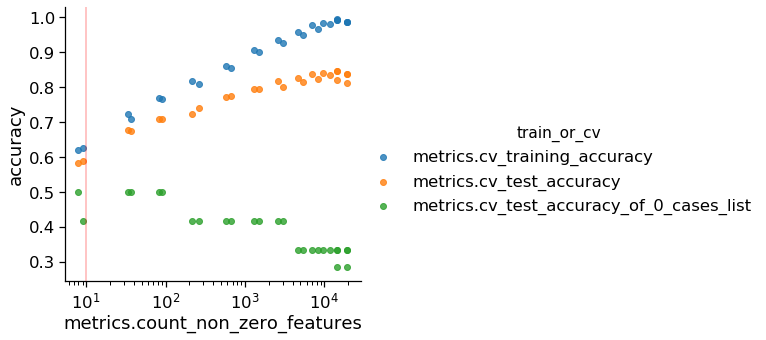

In [238]:
# Get the experiment id from the experiment name
curr_experiment_id=mlflow.get_experiment_by_name('V4-l1-Logistic_Regression_Exp').experiment_id

experiment_results_v4_df = mlflow.search_runs(experiment_ids=curr_experiment_id)

# Melt the dataframe to get accuracy as a single column
experiment_results_v4_df_melt = experiment_results_v4_df.melt(id_vars=['run_id','metrics.count_non_zero_features','params.lower_quantile_removed_CoV','params.log10_C','params.log10_max_iter'],
    value_vars=['metrics.cv_training_accuracy','metrics.cv_test_accuracy','metrics.cv_test_accuracy_of_0_cases_list'],
    var_name='train_or_cv',
    value_name='accuracy')

sns.lmplot(x='metrics.count_non_zero_features',
           y='accuracy',
           data=experiment_results_v4_df_melt,
           hue='train_or_cv', 
           fit_reg=False, size=5, aspect=1.25)

ax = plt.gca()
ax.set_xscale('log')
ax.axvline(10, c='r', alpha=0.3)

* This shows me that the ideal feature count is somewhere around 20-100. 
   * This is because it has a good overall accuracy, while predicting the negative class the best (near 50% accuracy). 
   * Well, this is actually not great since 50% accuracy is as good as a coin-flip. 

# Looking at selected features

In [153]:
curr_param_index = 0
curr_params_dict = {'C': 2e-2,
                    'max_iter': 1000,
                    'solver': 'saga',
                    'class_weight': None,
                    'lower_quantile_removed_CoV': 0.25}

# Load the gene expression (GE) raw data from file
X, y, phenotype_df = data_loading.load_sc1_data()

# Remove the lowest quartile of genes based on CoV
# Calculate the CoV
gene_expr_cov_list = 100 * (X.std(ddof=1, axis=0) / X.mean(axis=0))

# Calculate the 0.25 quantile
min_cov_threshold = np.quantile(gene_expr_cov_list, q=[curr_params_dict['lower_quantile_removed_CoV']])[0]

# Get a list of genes to removed
low_cov_gene_list = gene_expr_cov_list.loc[(gene_expr_cov_list < min_cov_threshold)].index.tolist()

# Remove the lowest 0.25 quantile of genes based on CoV
X.drop(low_cov_gene_list, axis=1, inplace=True)

# Run SMOTE on the X,y data
smote_obj = imblearn.over_sampling.SMOTE(sampling_strategy='auto', 
                                         random_state=110, 
                                         k_neighbors=5, 
                                         n_jobs=None)
X_smote, y_smote = smote_obj.fit_sample(X, y)

# Split into CV/test set using target class to stratify
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, stratify=y_smote)

# Define the model
log_regr_clf = LogisticRegression(penalty='l1',
                                  C=curr_params_dict['C'],
                                  class_weight=curr_params_dict['class_weight'],
                                  random_state=110,
                                  solver=curr_params_dict['solver'],
                                  max_iter=curr_params_dict['max_iter'],
                                  verbose=0,
                                  n_jobs=None,
                                  l1_ratio=None)

# Run CV
cv_accuracy_list = cross_val_score(estimator=log_regr_clf,
                                   X=X_train,
                                   y=y_train,
                                   groups=None,
                                   scoring='accuracy',
                                   cv=5,
                                   n_jobs=-1)

# Train the model
log_regr_clf.fit(X_train, y_train)

# Predict training data
y_train_pred = pd.Series(log_regr_clf.predict(X_train), index=y_train.index)

# Calculate result metrics like accuracy
training_accuracy = (y_train_pred == y_train).mean()

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [157]:
cv_accuracy_list

array([0.7047619 , 0.64423077, 0.625     , 0.67307692, 0.59615385])

In [154]:
print(f'There are {np.sum(log_regr_clf.coef_[0] != 0)} non-zero features in the Logistic Regression model')
non_zero_gene_list = X_smote.columns[log_regr_clf.coef_[0] != 0]

There are 38 non-zero features in the Logistic Regression model


In [155]:
[curr_gene for curr_gene in non_zero_gene_list]

['ADM',
 'ARL4C',
 'COL15A1',
 'CRNDE',
 'CXCL14',
 'DLL3',
 'EMX2',
 'ESM1',
 'FLJ16779',
 'GOLGA8A',
 'GPX3',
 'HOXA5',
 'IGFBP2',
 'IL13RA2',
 'LINC01088',
 'LPL',
 'MTHFD2',
 'NMB',
 'NPTX2',
 'NRN1',
 'PCDHB7',
 'PCP4',
 'PKIB',
 'PLAT',
 'RBP1',
 'RCAN2',
 'SFRP2',
 'SLC39A12',
 'SNX10',
 'STMN2',
 'SYNGR3',
 'SYT1',
 'SYTL4',
 'TENM2',
 'TIMP1',
 'TMEM100',
 'TMEM158',
 'TRDC']

# V5 - Eliminating more quantiles of genes based on CoV

## Running MLFlow

In [41]:
%%time

# Set the experiment name
mlflow.set_tracking_uri(f'file://{experiment_base_path}')
mlflow.set_experiment('SC1-V9-l1-Logistic_Regression_Exp')
    
# Define the parameter grid
param_dict = {'C': np.logspace(-2, 0, 5).tolist() + np.logspace(1, 5, 3).tolist(),
             'max_iter': [1000],
             'solver': ['saga'],
             'class_weight': [None],
             'lower_quantile_removed_CoV': [0, 0.25, 0.5, 0.9]}

# Load the gene expression (GE) raw data from file
X, y, phenotype_df = data_loading.load_sc1_data()
        
# Split into CV/test set using target class to stratify
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=110)

# Run mlflow runs in parallel
results = joblib.Parallel(n_jobs=-1, backend='multiprocessing')\
    (joblib.delayed(run_mlflow_exp_v9)(X_cv, X_test, y_cv, y_test, curr_param_index, curr_params_dict)\
         for curr_param_index, curr_params_dict in enumerate(ParameterGrid(param_dict)))

INFO: 'SC1-V9-l1-Logistic_Regression_Exp' does not exist. Creating a new experiment


/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

## Plotting # of features vs. training/CV accuracy

In [44]:
# Get the experiment id from the experiment name
curr_experiment_id=mlflow.get_experiment_by_name('SC1-V9-l1-Logistic_Regression_Exp').experiment_id

experiment_results_v9_df = mlflow.search_runs(experiment_ids=curr_experiment_id)

# Melt the dataframe to get accuracy as a single column
experiment_results_v9_df_melt = experiment_results_v9_df\
    .melt(id_vars=['run_id','metrics.count_non_zero_features','params.lower_quantile_removed_CoV',
                   'params.log10_C','params.log10_max_iter'],
          value_vars=['metrics.cv_training_accuracy','metrics.cv_test_accuracy',
                      'metrics.cv_test_0_class_accuracy','metrics.test_accuracy','metrics.test_auc'],
          var_name='train_or_cv',
          value_name='accuracy')

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


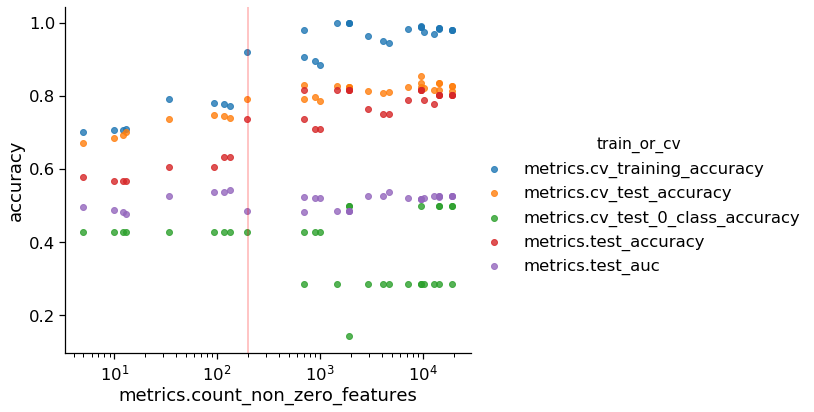

In [45]:
sns.lmplot(x='metrics.count_non_zero_features',
           y='accuracy',
           data=experiment_results_v9_df_melt,
           hue='train_or_cv',
           fit_reg=False, size=6, aspect=1.25)

ax = plt.gca()
ax.set_xscale('log')
ax.axvline(200, c='r', alpha=0.3)

In [32]:
experiment_results_v9_df_melt\
    .loc[(experiment_results_v9_df_melt['metrics.count_non_zero_features'] > 150)
        & (experiment_results_v9_df_melt['metrics.count_non_zero_features'] < 300)]

,run_id,metrics.count_non_zero_features,params.lower_quantile_removed_CoV,params.log10_C,params.log10_max_iter,train_or_cv,accuracy
20,96629e4a9fe749f0a1170e0798f426d0,194.0,0.9,-1.0,3.0,metrics.cv_training_accuracy,0.920263
52,96629e4a9fe749f0a1170e0798f426d0,194.0,0.9,-1.0,3.0,metrics.cv_test_accuracy,0.790383
84,96629e4a9fe749f0a1170e0798f426d0,194.0,0.9,-1.0,3.0,metrics.cv_test_0_class_accuracy,0.428571
116,96629e4a9fe749f0a1170e0798f426d0,194.0,0.9,-1.0,3.0,metrics.test_accuracy,0.736842


# Investigating the best class 0 prediction cases

In [41]:
experiment_results_v5_df.loc[np.abs(experiment_results_v5_df['params.log10_C'] + 0.88888889) < 0.01]

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.cv_test_accuracy_of_0_cases_list,metrics.cv_test_accuracy,metrics.cv_training_accuracy,metrics.count_non_zero_features,params.log10_C,params.lower_quantile_removed_CoV,params.class_weight,params.log10_max_iter,params.solver,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.source.type,tags.description
42,4231b3a96107473b9abe51d2a8933656,5,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-16 02:21:51.954000+00:00,2020-01-16 02:22:36.770000+00:00,0.428571,0.774317,0.947683,176.0,-0.888889,0.95,None,3.0,saga,alex,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...,LOCAL,"\n In this run, I added a parameter tha..."
43,6bb141c353be4436a7990bae6b6ba354,5,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-16 02:20:59.958000+00:00,2020-01-16 02:22:24.774000+00:00,0.555556,0.807541,0.944336,282.0,-0.888889,0.9,None,3.0,saga,alex,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...,LOCAL,"\n In this run, I added a parameter tha..."
44,1b96e3e173044bb4b3bbfbd42f344e8d,5,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-16 02:20:49.186000+00:00,2020-01-16 02:24:19.841000+00:00,0.428571,0.780929,0.945197,657.0,-0.888889,0.75,None,3.0,saga,alex,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...,LOCAL,"\n In this run, I added a parameter tha..."
45,e3b4875959514163bba95e87fce4c63d,5,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-16 02:20:46.267000+00:00,2020-01-16 02:27:47.009000+00:00,0.555556,0.800929,0.930221,1055.0,-0.888889,0.5,None,3.0,saga,alex,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...,LOCAL,"\n In this run, I added a parameter tha..."
46,31591152e60a4b49b8916e3447c29bbf,5,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-16 02:20:05.641000+00:00,2020-01-16 02:30:21.223000+00:00,0.285714,0.757541,0.911134,1418.0,-0.888889,0.25,None,3.0,saga,alex,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...,LOCAL,"\n In this run, I added a parameter tha..."
47,81ad9c25e6764a4eb77d7e587d85783e,5,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-16 02:20:03.595000+00:00,2020-01-16 02:33:26.318000+00:00,0.285714,0.760874,0.900342,1648.0,-0.888889,0,None,3.0,saga,alex,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...,LOCAL,"\n In this run, I added a parameter tha..."


So the best performing model had paramters:
* log10_C between [-0.88889, -0.66667]
* lower_quantile_removed_CoV between [0.5, 0.9]

In [25]:
experiment_results_v5_df.dtypes

run_id                                                   object
experiment_id                                            object
status                                                   object
artifact_uri                                             object
start_time                                  datetime64[ns, UTC]
end_time                                    datetime64[ns, UTC]
metrics.cv_test_accuracy_of_0_cases_list                float64
metrics.cv_test_accuracy                                float64
metrics.cv_training_accuracy                            float64
metrics.count_non_zero_features                         float64
params.log10_C                                          float64
params.lower_quantile_removed_CoV                        object
params.class_weight                                      object
params.log10_max_iter                                    object
params.solver                                            object
tags.mlflow.user                        

In [19]:
experiment_results_v5_df\
    .loc[(experiment_results_v5_df['metrics.cv_test_accuracy_of_0_cases_list'] > 0.5)]\
    .iloc[:, 6:]

,metrics.cv_test_accuracy_of_0_cases_list,metrics.cv_test_accuracy,metrics.cv_training_accuracy,metrics.count_non_zero_features,params.log10_C,params.lower_quantile_removed_CoV,params.class_weight,params.log10_max_iter,params.solver,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.source.type,tags.description
23,0.625000,0.840765,0.970107,12039.0,0.000000,0,None,3.0,saga,alex,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...,LOCAL,"\n In this run, I added a parameter tha..."
34,0.625000,0.830765,0.955149,4886.0,-0.444444,0.25,None,3.0,saga,alex,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...,LOCAL,"\n In this run, I added a parameter tha..."
37,0.555556,0.814098,0.978396,502.0,-0.666667,0.9,None,3.0,saga,alex,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...,LOCAL,"\n In this run, I added a parameter tha..."
38,0.555556,0.810820,0.967604,1103.0,-0.666667,0.75,None,3.0,saga,alex,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...,LOCAL,"\n In this run, I added a parameter tha..."
39,0.625000,0.817596,0.948510,2068.0,-0.666667,0.5,None,3.0,saga,alex,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...,LOCAL,"\n In this run, I added a parameter tha..."
43,0.555556,0.807541,0.944336,282.0,-0.888889,0.9,None,3.0,saga,alex,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...,LOCAL,"\n In this run, I added a parameter tha..."
45,0.555556,0.800929,0.930221,1055.0,-0.888889,0.5,None,3.0,saga,alex,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...,LOCAL,"\n In this run, I added a parameter tha..."


# Getting features of model

In [4]:
def run_mlflow_exp_v6(curr_param_index, curr_params_dict):
    # Set the experiment name
    mlflow.set_tracking_uri(f'file://{experiment_base_path}')
    #mlflow.set_experiment('V4-l1-Logistic_Regression_Exp')
    
    # Start a mlflow run
    with mlflow.start_run():
        mlflow.set_tag('description', 
        """
        In this run, I added a parameter that controls what lower quantile of the data is removed based on CoV.
        """)
        
        # Define the model
        log_regr_clf = LogisticRegression(penalty='l1',
                                          C=curr_params_dict['C'],
                                          class_weight=curr_params_dict['class_weight'],
                                          random_state=110,
                                          solver=curr_params_dict['solver'],
                                          max_iter=curr_params_dict['max_iter'],
                                          verbose=0,
                                          n_jobs=None,
                                          l1_ratio=None)
        
        #print(curr_param_index, curr_params_dict)
        # Define the description and tags
        #mlflow_funcs.define_description_and_tags(mlflow)

        # Load the gene expression (GE) raw data from file
        X, y, phenotype_df = data_loading.load_sc1_data()
        
        # Remove the lowest quartile of genes based on CoV
        # Calculate the CoV
        gene_expr_cov_list = 100 * (X.std(ddof=1, axis=0) / X.mean(axis=0))
        
        # Calculate the 0.25 quantile
        min_cov_threshold = np.quantile(gene_expr_cov_list, q=[curr_params_dict['lower_quantile_removed_CoV']])[0]
        
        # Get a list of genes to removed
        low_cov_gene_list = gene_expr_cov_list.loc[(gene_expr_cov_list < min_cov_threshold)].index.tolist()
        
        # Remove the lowest 0.25 quantile of genes based on CoV
        X.drop(low_cov_gene_list, axis=1, inplace=True)

        # Split into CV/test set using target class to stratify
        X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
        
        # Run custom CV so I can train on over-sampled data but test on original data
        kfold_obj = KFold(n_splits=5, shuffle=True)

        cv_train_accuracy_list = []
        cv_test_accuracy_list = []
        cv_test_accuracy_of_0_cases_list = []
        
        for curr_train_iloc_list, curr_test_iloc_list in kfold_obj.split(X=X_cv, y=y_cv):

            # Create current fold train data
            curr_fold_X_train = X_cv.iloc[curr_train_iloc_list, ]
            curr_fold_y_train = y_cv.iloc[curr_train_iloc_list, ]
            
            # Create current fold train data
            curr_fold_X_test = X_cv.iloc[curr_test_iloc_list, ]
            curr_fold_y_test = y_cv.iloc[curr_test_iloc_list, ]

            # Run SMOTE on the X,y data
            smote_obj = imblearn.over_sampling.SMOTE(sampling_strategy='auto', 
                                                     random_state=110, 
                                                     k_neighbors=5, 
                                                     n_jobs=None)

            curr_fold_X_train_smote, curr_fold_y_train_smote = smote_obj.fit_sample(curr_fold_X_train, curr_fold_y_train)

            # Train the model on the over-sampled (SMOTE) training data for this k-fold
            log_regr_clf.fit(curr_fold_X_train_smote, curr_fold_y_train_smote)

            # Calculate accuracy on non-oversampled data
            curr_fold_y_train_pred = pd.Series(log_regr_clf.predict(curr_fold_X_train), index=curr_fold_y_train.index)
            curr_fold_y_test_pred = pd.Series(log_regr_clf.predict(curr_fold_X_test), index=curr_fold_y_test.index)

            # Calculate result metrics like accuracy
            cv_train_accuracy_list.append((curr_fold_y_train_pred == curr_fold_y_train).mean())
            cv_test_accuracy_list.append((curr_fold_y_test_pred == curr_fold_y_test).mean())
            
            # Calculate the test accuracy of target=0 cases
            cv_test_accuracy_of_0_cases_list = np.mean(curr_fold_y_test_pred[(curr_fold_y_test == 0)] == 0)
            
        
        # Run SMOTE on the full X_cv,y_cv data
        smote_obj = imblearn.over_sampling.SMOTE(sampling_strategy='auto', 
                                                 random_state=110, 
                                                 k_neighbors=5, 
                                                 n_jobs=None)
        X_cv_smote, y_cv_smote = smote_obj.fit_sample(X_cv, y_cv)
        
        # Train the model
        log_regr_clf.fit(X_cv_smote, y_cv_smote)
        
        # Log parameters
        mlflow.log_param("log10_C", np.log10(curr_params_dict['C']))
        mlflow.log_param("log10_max_iter", np.log10(curr_params_dict['max_iter']))
        mlflow.log_param("solver", curr_params_dict['solver'])
        mlflow.log_param("class_weight", curr_params_dict['class_weight'])
        mlflow.log_param("lower_quantile_removed_CoV", curr_params_dict['lower_quantile_removed_CoV'])
        
        # Log accuracy metrics
        mlflow.log_metric("cv_training_accuracy", np.mean(cv_train_accuracy_list))
        mlflow.log_metric("cv_test_accuracy", np.mean(cv_test_accuracy_list))
        mlflow.log_metric("cv_test_accuracy_of_0_cases_list", np.mean(cv_test_accuracy_of_0_cases_list))

        # Log count of non-zero features
        mlflow.log_metric("count_non_zero_features", np.sum(log_regr_clf.coef_[0] != 0))
        
        # Log sensitivity, specificity
        
        # Log AUC
        
        #mlflow.sklearn.log_model(svm_clf, "model")

In [36]:
# Define the model
log_regr_clf = LogisticRegression(penalty='l1',
                                  C=1e-1,
                                  class_weight=None,
                                  random_state=110,
                                  solver='saga',
                                  max_iter=50,
                                  verbose=0,
                                  n_jobs=None,
                                  l1_ratio=None)

# Load the gene expression (GE) raw data from file
X, y, phenotype_df = data_loading.load_sc1_data()

# Split into CV/test set using target class to stratify
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Run SMOTE on the full X_cv,y_cv data
smote_obj = imblearn.over_sampling.SMOTE(sampling_strategy='auto', 
                                         random_state=110, 
                                         k_neighbors=5, 
                                         n_jobs=None)
X_cv_smote, y_cv_smote = smote_obj.fit_sample(X_cv, y_cv)

# Train the model
log_regr_clf.fit(X_cv_smote, y_cv_smote)

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=50,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=110, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
# Getting the top genes
coef_list = pd.Series(log_regr_clf.coef_[0], index=X_cv.columns.tolist())

for i in np.abs(coef_list).sort_values(ascending=False).head(100).index:
    print(i)

PLAT
MTHFD2
NRN1
LINC01088
FLJ16779
EMX2
CHI3L1
SLC14A1
SYTL4
CRNDE
PHLDA2
TIMP1
CXCL14
SNX10
NPTX2
IL13RA2
ETNPPL
GPX3
RCAN2
ARL4C
IGFBP2
SELL
TMEM158
PRKX
ESM1
IGFBP6
FAM110C
PBK
HOXC6
CASTOR1
TOP2A
PKIB
ZBTB16
ZNF665
ELMOD1
SLC24A3
DLL3
ENC1
NKAIN4
COL15A1
EMP3
SHD
PCDHB7
COL4A2
RBP1
SHISA6
SERPINE1
SCN2A
SFRP2
HOXA5
H19
IRX1
CHODL
TMEM100
STMN2
SNHG19
RRM2
KIF4A
COL4A1
PLA2G7
CTHRC1
SYT1
ISG15
MERTK
METTL7B
CAV1
LOXL1
AKR1C3
TM4SF1
C11orf96
GJB2
GABRB1
NEFH
AMIGO2
RGS17
GPR34
PDPN
BMP2
GBP1
KISS1R
TENM2
PSD3
RIDA
RNF128
EGFEM1P
PTX3
USP54
USH1C
CSDC2
XIST
SYNGR3
EBF4
FERMT1
SNHG1
NMB
FAM107A
CTSK
CHRNA9
OSBPL11
BCAT1


In [42]:
[print(i) for i in coef_list.sort_values(ascending=False).head(50).index]

PLAT
NRN1
CHI3L1
CRNDE
PHLDA2
TIMP1
CXCL14
SNX10
IL13RA2
RCAN2
ARL4C
IGFBP2
TMEM158
ESM1
IGFBP6
FAM110C
PBK
HOXC6
TOP2A
PKIB
ZNF665
ELMOD1
ENC1
COL15A1
EMP3
PCDHB7
COL4A2
RBP1
SERPINE1
SCN2A
HOXA5
H19
IRX1
CHODL
STMN2
RRM2
KIF4A
COL4A1
CTHRC1
SYT1
ISG15
METTL7B
CAV1
LOXL1
TM4SF1
GJB2
NEFH
AMIGO2
RGS17
PDPN


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [40]:
coef_list.sort_values(ascending=False).tail(50)

SESN1       -0.002326
MT1X        -0.002331
BEST3       -0.002345
RTKN        -0.002360
PRLHR       -0.002362
HAPLN1      -0.002365
CNTN3       -0.002394
F5          -0.002419
TRDC        -0.002420
C1QB        -0.002434
ABCC8       -0.002439
OSBPL11     -0.002495
FAM107A     -0.002521
NMB         -0.002524
SNHG1       -0.002530
FERMT1      -0.002541
EBF4        -0.002558
XIST        -0.002578
CSDC2       -0.002580
USH1C       -0.002588
USP54       -0.002603
RIDA        -0.002673
BMP2        -0.002748
GPR34       -0.002763
GABRB1      -0.002819
C11orf96    -0.002833
AKR1C3      -0.002849
MERTK       -0.002896
PLA2G7      -0.002959
SNHG19      -0.003023
TMEM100     -0.003068
SFRP2       -0.003146
SHISA6      -0.003183
SHD         -0.003219
NKAIN4      -0.003311
DLL3        -0.003340
SLC24A3     -0.003363
ZBTB16      -0.003396
CASTOR1     -0.003440
PRKX        -0.003576
SELL        -0.003630
GPX3        -0.004094
ETNPPL      -0.004105
NPTX2       -0.004195
SYTL4       -0.004827
SLC14A1   

# Exp 1 - Increasing maximum iters to see if performance improves

In [48]:
%%time

# Set the experiment name
mlflow.set_tracking_uri(f'file://{experiment_base_path}')
mlflow.set_experiment('SC1-V9-Exp_1-L1-Logistic_Regression_Exp')
    
# Define the parameter grid
param_dict = {'C': [1e-2, 1e-1, 1],
             'max_iter': [1000, 10000],
             'solver': ['saga'],
             'class_weight': [None],
             'lower_quantile_removed_CoV': [0, 0.25, 0.5, 0.9]}

# Load the gene expression (GE) raw data from file
X, y, phenotype_df = data_loading.load_sc1_data()
        
# Split into CV/test set using target class to stratify
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=110)

# Run mlflow runs in parallel
results = joblib.Parallel(n_jobs=-1, backend='multiprocessing')\
    (joblib.delayed(run_mlflow_exp_v9)(X_cv, X_test, y_cv, y_test, curr_param_index, curr_params_dict)\
         for curr_param_index, curr_params_dict in enumerate(ParameterGrid(param_dict)))

INFO: 'SC1-V9-Exp_1-L1-Logistic_Regression_Exp' does not exist. Creating a new experiment


/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CPU times: user 6.07 s, sys: 1.17 s, total: 7.23 s
Wall time: 59min 41s


In [50]:
# Get the experiment id from the experiment name
curr_experiment_id=mlflow.get_experiment_by_name('SC1-V9-Exp_1-L1-Logistic_Regression_Exp').experiment_id

experiment_results_v9_exp_1_df = mlflow.search_runs(experiment_ids=curr_experiment_id)

# Melt the dataframe to get accuracy as a single column
experiment_results_v9_exp_1_df_melt = experiment_results_v9_exp_1_df\
    .melt(id_vars=['run_id','metrics.count_non_zero_features','params.lower_quantile_removed_CoV',
                   'params.log10_C','params.log10_max_iter'],
          value_vars=['metrics.cv_training_accuracy','metrics.cv_test_accuracy',
                      'metrics.cv_test_0_class_accuracy','metrics.test_accuracy','metrics.test_auc'],
          var_name='train_or_cv',
          value_name='accuracy')

**Increaing the # of max_iterations from 1,000 to 10,000 didn't improve the performance**

# Exp 2 - Investigating the train and test AUC

In [58]:
%%time

# Set the experiment name
mlflow.set_tracking_uri(f'file://{experiment_base_path}')
mlflow.set_experiment('SC1-V9-Exp_2-L1-Logistic_Regression_Exp')
    
# Define the parameter grid
# Define the parameter grid
param_dict = {'C': np.logspace(-2, 0, 5).tolist() + np.logspace(1, 5, 3).tolist(),
             'max_iter': [100, 1000],
             'solver': ['saga'],
             'class_weight': [None],
             'lower_quantile_removed_CoV': [0, 0.25, 0.5, 0.9]}

# Load the gene expression (GE) raw data from file
X, y, phenotype_df = data_loading.load_sc1_data()
        
# Split into CV/test set using target class to stratify
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=110)

# Run mlflow runs in parallel
results = joblib.Parallel(n_jobs=-1, backend='multiprocessing')\
    (joblib.delayed(run_mlflow_exp_v9)(X_cv, X_test, y_cv, y_test, curr_param_index, curr_params_dict)\
         for curr_param_index, curr_params_dict in enumerate(ParameterGrid(param_dict)))

INFO: 'SC1-V9-Exp_2-L1-Logistic_Regression_Exp' does not exist. Creating a new experiment


/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

CPU times: user 4.69 s, sys: 630 ms, total: 5.32 s
Wall time: 19min 37s


In [59]:
# Get the experiment id from the experiment name
curr_experiment_id=mlflow.get_experiment_by_name('SC1-V9-Exp_2-L1-Logistic_Regression_Exp').experiment_id

experiment_results_v9_exp_2_df = mlflow.search_runs(experiment_ids=curr_experiment_id)\
    .rename(columns={'metrics.cv_test_accuracy_of_0_cases_list': 'metrics.cv_test_0_class_accuracy'})

experiment_results_v9_exp_2_df.loc[:, ['params.log10_C','metrics.count_non_zero_features','metrics.train_auc','metrics.test_auc']]

,params.log10_C,metrics.count_non_zero_features,metrics.train_auc,metrics.test_auc
0,5.0,1934.0,1.000000,0.486364
1,5.0,1934.0,0.971857,0.504545
2,5.0,9668.0,0.999625,0.518182
3,5.0,9668.0,0.934428,0.568182
4,5.0,14501.0,0.998874,0.525758
...,...,...,...,...
59,-2.0,25.0,0.701407,0.453030
60,-2.0,12.0,0.701313,0.483333
61,-2.0,28.0,0.696998,0.457576
62,-2.0,13.0,0.702627,0.475758


In [75]:
experiment_results_v9_exp_2_df.loc[:, ['params.log10_C','metrics.count_non_zero_features',
                                       'metrics.train_auc','metrics.cv_test_accuracy','metrics.test_auc']]\
    .iloc[31:80, :]\
    .sort_values('metrics.count_non_zero_features')

,params.log10_C,metrics.count_non_zero_features,metrics.train_auc,metrics.cv_test_accuracy,metrics.test_auc
55,-2.0,5.0,0.706567,0.670765,0.495455
58,-2.0,10.0,0.704784,0.683934,0.487879
60,-2.0,12.0,0.701313,0.693934,0.483333
57,-2.0,12.0,0.705722,0.703934,0.478788
62,-2.0,13.0,0.702627,0.700601,0.475758
59,-2.0,25.0,0.701407,0.724044,0.453030
61,-2.0,28.0,0.696998,0.720710,0.457576
63,-2.0,30.0,0.695779,0.727377,0.454545
48,-1.5,34.0,0.881614,0.737104,0.525758
51,-1.5,94.0,0.856285,0.747104,0.537879


In [73]:
experiment_results_v9_exp_2_df\
    .iloc[[40,52], 6:]

,metrics.cv_test_accuracy,metrics.train_auc,metrics.cv_test_0_class_accuracy,metrics.test_accuracy,metrics.test_auc,metrics.count_non_zero_features,metrics.cv_training_accuracy,params.log10_max_iter,params.log10_C,params.class_weight,params.lower_quantile_removed_CoV,params.solver,tags.description,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.user
40,0.790383,0.977767,0.428571,0.736842,0.486364,194.0,0.920263,3.0,-1.0,None,0.9,saga,"\n In this run, I added a parameter tha...",LOCAL,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...,alex
52,0.743770,0.840338,0.428571,0.631579,0.537879,117.0,0.776549,3.0,-1.5,None,0.25,saga,"\n In this run, I added a parameter tha...",LOCAL,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...,alex


So it seems like using only ~30 predictors is not quite enough to generate a good model; The test accuracy and AUC is very close to 50%. This can be improved by 

# Exp 3 - Experimenting on multiple CV/Test data

## Quick test

In [25]:
%%time

# Set the experiment name
mlflow.set_tracking_uri(f'file://{experiment_base_path}')
mlflow.set_experiment('SC1-V10-TEST-L1-Logistic_Regression_Exp')

# Load the gene expression (GE) raw data from file
X, y, phenotype_df = data_loading.load_sc1_data()

X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

model_funcs.run_mlflow_exp_V10(X_cv, X_test, y_cv, y_test, test_param_dict, experiment_base_path)

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

> /home/alex/data-science/brain_cancer_precfda/src/model_funcs.py(219)run_mlflow_exp_V10()
-> mlflow.log_artifact(confusion_output_path)
(Pdb) pd.DataFrame(confusion_matrix, columns=['0_pred','1_pred'], index=['0_actual','1_actual'])
          0_pred  1_pred
0_actual       3       7
1_actual      12      54
(Pdb) y_test
PATIENTID
patient_371    1
patient_61     1
patient_305    1
patient_351    1
patient_336    1
              ..
patient_414    0
patient_25     1
patient_80     0
patient_104    1
patient_212    1
Name: SURVIVAL_STATUS, Length: 76, dtype: int64
(Pdb) y_test.value_counts()
1    66
0    10
Name: SURVIVAL_STATUS, dtype: int64
(Pdb) exit()


BdbQuit: 

## Running full MLFlow Exp

In [ ]:
%%time

# Set the experiment name
mlflow.set_tracking_uri(f'file://{experiment_base_path}')
mlflow.set_experiment('SC1-V10-Exp_3-L1-Logistic_Regression_Exp')
    
# Define the parameter grid
param_dict = {'C': np.logspace(-2, 0, 9).tolist() + np.logspace(1, 5, 3).tolist(),
             'max_iter': [100],
             'solver': ['saga'],
             'class_weight': [None],
             'lower_quantile_removed_CoV': [0, 0.25, 0.5, 0.9],
             'use_smote': [True]}

# Load the gene expression (GE) raw data from file
X, y, phenotype_df = data_loading.load_sc1_data()

for i in range(15):
    # Split into CV/test set using target class to stratify
    X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    #model_funcs.run_mlflow_exp_V10(X_cv, X_test, y_cv, y_test, test_param_dict, experiment_base_path)

    # Run mlflow runs in parallel
    results = joblib.Parallel(n_jobs=-1, backend='multiprocessing')\
        (joblib.delayed(model_funcs.run_mlflow_exp_V10)(X_cv, X_test, y_cv, y_test, curr_params_dict, experiment_base_path)\
             for curr_param_index, curr_params_dict in enumerate(ParameterGrid(param_dict)))

## Creating a dataframe with experiment results

In [27]:
# Get the experiment id from the experiment name
curr_experiment_id=mlflow.get_experiment_by_name('SC1-V10-Exp_3-L1-Logistic_Regression_Exp').experiment_id

experiment_results_sc1_v10_exp3_df = mlflow.search_runs(experiment_ids=curr_experiment_id)\
    .rename(columns={'metrics.cv_test_accuracy_of_0_cases_list': 'metrics.cv_test_0_class_accuracy'})

# Melt the dataframe to get accuracy as a single column
experiment_results_sc1_v10_exp3_df_melt = experiment_results_sc1_v10_exp3_df\
    .melt(id_vars=['run_id','metrics.count_non_zero_features','params.lower_quantile_removed_CoV','params.log10_C','params.log10_max_iter','params.use_smote'],
          value_vars=['metrics.cv_training_accuracy','metrics.cv_test_accuracy','metrics.cv_test_0_class_accuracy'],
          var_name='train_or_cv',
          value_name='accuracy')

experiment_results_sc1_v10_exp3_df_melt['metrics.log10_count_non_zero_features'] = np.log10(experiment_results_sc1_v10_exp3_df_melt['metrics.count_non_zero_features'] + 1)

## Plotting the results

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


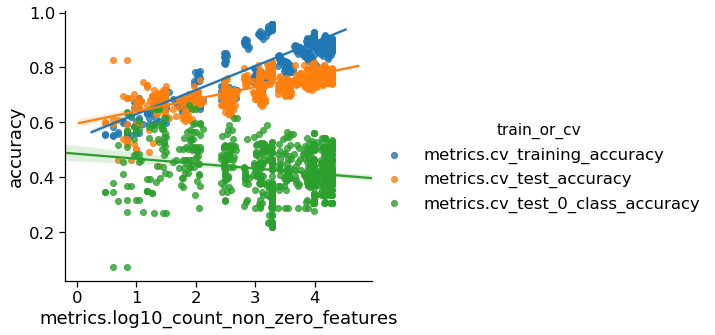

In [28]:
plot_df = experiment_results_sc1_v10_exp3_df_melt\
    .loc[experiment_results_sc1_v10_exp3_df_melt['metrics.count_non_zero_features'] > 1]

sns.lmplot(x='metrics.log10_count_non_zero_features',
           y='accuracy',
           data=plot_df,
           hue='train_or_cv', 
           fit_reg=True, size=5, aspect=1.25)

ax = plt.gca()
#ax.set_xscale('log')
#ax.axvline(3, c='r', alpha=0.3)

In [32]:
experiment_results_sc1_v10_exp3_df.columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.test_specificity', 'metrics.cv_training_accuracy',
       'metrics.cv_test_accuracy', 'metrics.train_accuracy',
       'metrics.test_sensitivity', 'metrics.cv_test_auc',
       'metrics.count_non_zero_features', 'metrics.train_auc',
       'metrics.cv_test_0_class_accuracy', 'metrics.test_accuracy',
       'metrics.test_auc', 'params.log10_C', 'params.class_weight',
       'params.use_smote', 'params.lower_quantile_removed_CoV',
       'params.log10_max_iter', 'params.solver', 'tags.mlflow.source.type',
       'tags.mlflow.user', 'tags.mlflow.source.name', 'tags.description'],
      dtype='object')

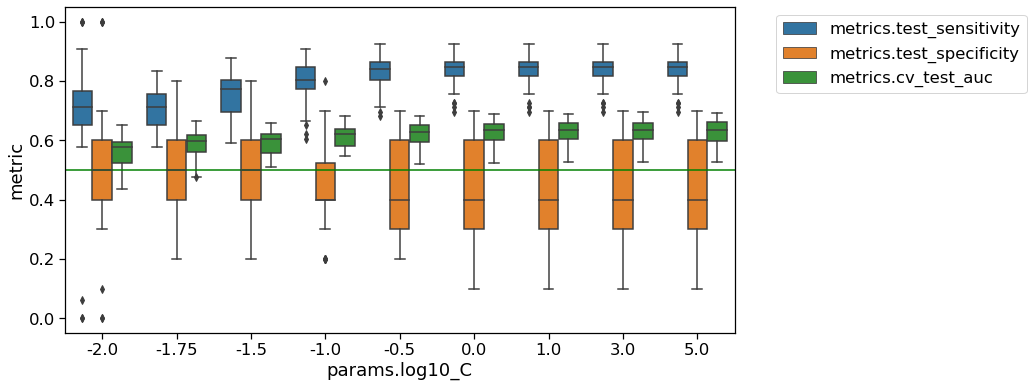

In [43]:
# Melt the dataframe to get accuracy as a single column
plot_df = experiment_results_sc1_v10_exp3_df\
    .melt(id_vars=['run_id','metrics.count_non_zero_features','params.lower_quantile_removed_CoV','params.log10_C','params.log10_max_iter','params.use_smote'],
          value_vars=['metrics.test_sensitivity','metrics.test_specificity','metrics.cv_test_auc'],
          var_name='train_or_cv',
          value_name='metric')

plt.figure(figsize=(12,6))
ax=plt.gca()

sns.boxplot(x='params.log10_C',
           y='metric',
           data=plot_df,
           hue='train_or_cv', 
           order=['-2.0', '-1.75', '-1.5', '-1.0', '-0.5', '0.0', '1.0', '3.0', '5.0'],
           ax=ax)

ax.legend(bbox_to_anchor=(1.05,1))
ax.axhline(0.5, c='g')
#ax.axvline(1)

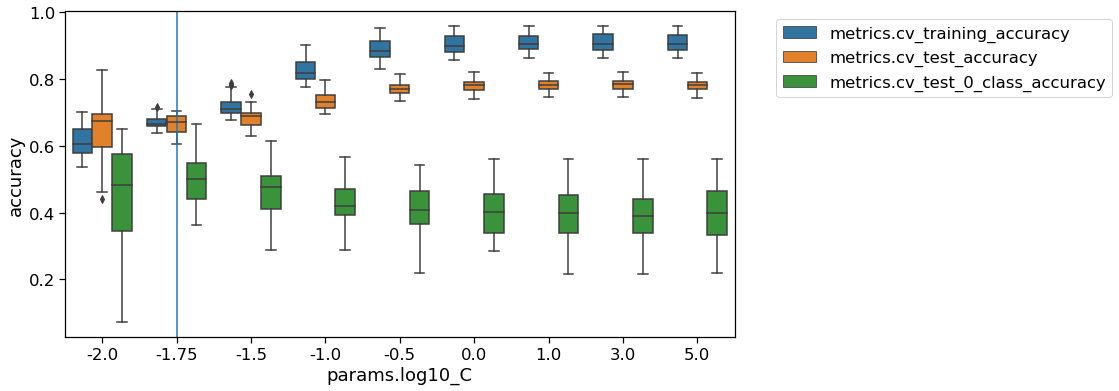

In [39]:
plot_df = experiment_results_sc1_v10_exp3_df_melt\
    .loc[experiment_results_sc1_v10_exp3_df_melt['metrics.count_non_zero_features'] > 1]

plt.figure(figsize=(12,6))
ax=plt.gca()

sns.boxplot(x='params.log10_C',
           y='accuracy',
           data=plot_df,
           hue='train_or_cv', 
           order=['-2.0', '-1.75', '-1.5', '-1.0', '-0.5', '0.0', '1.0', '3.0', '5.0'],
           ax=ax)

ax.legend(bbox_to_anchor=(1.05,1))
#ax.axhline(0.5, c='g')
ax.axvline(1)

In order to balance the performance of class 0 cases with overall test accuracy, a model with log10_C=-1.75 was chosen

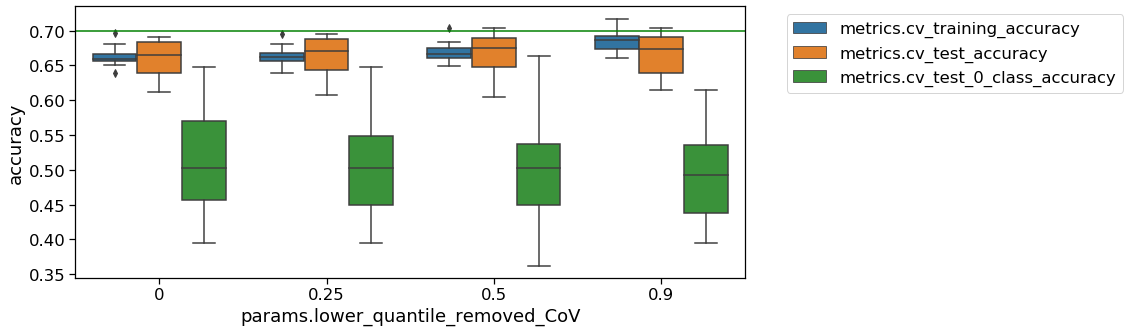

In [30]:
plot_df = experiment_results_sc1_v10_exp3_df_melt\
    .loc[experiment_results_sc1_v10_exp3_df_melt['metrics.count_non_zero_features'] > 1]\
    .loc[experiment_results_sc1_v10_exp3_df_melt['params.log10_C'] == '-1.75']

plt.figure(figsize=(12,5))
ax=plt.gca()

sns.boxplot(x='params.lower_quantile_removed_CoV',
           y='accuracy',
           data=plot_df,
           hue='train_or_cv', 
           ax=ax)

ax.legend(bbox_to_anchor=(1.05,1))
ax.axhline(0.7, c='g')
#ax.axvline(1)

After removing ~0.5 quantiles of lower CoV genes, the variance of class 0 accuracy increases. Therefore, I will remove only 0.25 quantiles of lower CoV genes. 

Final model:
* log10_C=-1.75
* lower_quantile_removed_CoV=0.25

In [56]:
experiment_results_sc1_v10_exp3_df\
    .loc[(experiment_results_sc1_v10_exp3_df['params.log10_C'] == '-1.75')
        & (experiment_results_sc1_v10_exp3_df['params.lower_quantile_removed_CoV'] == '0.25')]\
    .filter(regex='metrics.*')\
    .describe()

,metrics.cv_training_accuracy,metrics.count_non_zero_features,metrics.cv_test_auc,metrics.train_auc,metrics.test_accuracy,metrics.test_auc,metrics.cv_test_accuracy,metrics.cv_test_0_class_accuracy
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,0.672519,92.636364,0.614694,0.741403,0.667464,0.558402,0.687452,0.538355
std,0.009876,21.448882,0.023925,0.034118,0.060894,0.083760,0.019447,0.029462
min,0.651425,55.000000,0.586867,0.665725,0.552632,0.440909,0.661311,0.488889
25%,0.669076,80.500000,0.595450,0.738410,0.631579,0.500000,0.671093,0.529466
50%,0.672404,89.000000,0.607880,0.750976,0.657895,0.565152,0.687923,0.536688
75%,0.680473,111.000000,0.628189,0.754867,0.703947,0.600758,0.702705,0.556984
max,0.685065,124.000000,0.662570,0.789704,0.776316,0.713636,0.717814,0.590165


## Loading the feature lists for these models

In [4]:
# Get the full run_id list for this experiment
run_id_list = experiment_results_sc1_v10_exp3_df\
    .loc[(experiment_results_sc1_v10_exp3_df['params.log10_C'] == '-1.75')
        & (experiment_results_sc1_v10_exp3_df['params.lower_quantile_removed_CoV'] == '0.25')]\
    ['run_id']

In [5]:
full_feature_list = []

for curr_run_id in run_id_list:
    # Get the current run's artifact uri
    curr_run = mlflow.get_run(run_id=curr_run_id)
    curr_artifact_uri = curr_run.to_dictionary()['info']['artifact_uri']

    # Get the feature list filepath
    feature_list_filepath = glob.glob(f'{curr_artifact_uri[7:]}/*')[0]
    
    # Open the feature list file
    with open(feature_list_filepath, 'r') as f:
        # Get the first feature
        curr_feature = f.readline()

        # While the current feature name is not empty
        while curr_feature != '':
            # Add the feature to the full feature list
            full_feature_list.append(f.readline().strip())
            
            # Get the next feature
            curr_feature = f.readline()

(array([86., 41., 30., 17., 16., 13., 15.,  7.,  3.,  4.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <a list of 10 Patch objects>)

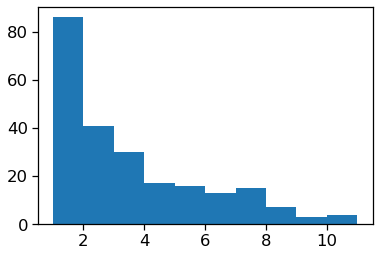

In [6]:
full_sc1_feature_ser = pd.Series(full_feature_list)
full_sc1_feature_counts_ser = full_sc1_feature_ser.value_counts()

plt.hist(full_sc1_feature_counts_ser)

This histogram shows that some features were found in nearly every model. These are the more likely candidates for predictive features

In [137]:
for i in full_sc1_feature_ser.unique().tolist():
    print(i)

AKR1C3
ARL4C
BCHE
BMP2
CASTOR1
CCL2
CHI3L2
CNTN3
COL20A1
COL4A2
CRNDE
CTHRC1
DLL1
EIF3E
EMX2
ESM1
FABP7
FERMT1
GDA
GOLGA8A
HOXA5
HOXC6
ID3
IL13RA2
KLRC3
LINC01088
LOXL1
LTF
METTL7B
MTHFD2
NEFL
NMB
NSUN6
PHLDA2
PKIB
PLAT
PTX3
RBP1
RIDA
SERPINE1
SHD
SLC39A12
SNX10
SYT1
TIMP1
TMEM158
USP54
ZBTB16
DLL3
GAP43
GJB2
GPX3
ID1
MERTK
NKAIN4
NRN1
PCDHB16
PDPN
SMOC1
SNHG19
STOX1
ADGRL2
AMIGO2
ANXA1
BCAT1
CHST9
COL4A1
DAAM2
DNM1
EMP3
ENC1
ETNPPL
FAM110C
FLJ16779
GABRA1
GNG3
HES6
IGFBP2
KCNN3
LRRC1
PRKX
RAB3IP
RCAN2
RNF128
SCN2A
SLC24A3
SNHG1
SYTL4
TENM2
TM4SF1
TPPP3
VANGL2
VSNL1
WIF1
ARHGEF26.AS1
CHI3L1
CXCL14
GAS1
GRB14
HAPLN1
LHFPL3
LOC401261
LRP1B
PCP4
TMEM100
TRDC

CDC20
COL1A1
COL3A1
GALNT13
H19
IGKC
KCNN2
LINC00844
LUM
NTN4
PBK
PDE8B
RRM2
SELL
SFRP2
SHISA6
SLCO1C1
SOD2
SRPX
TOP2A
VCAN
ADCYAP1R1
ASS1
BCAN
BEST3
C9orf24
COL15A1
CSRP2
EFNB2
GABRB1
ID4
LINC01094
LPL
OLIG2
PCDHB7
PPP1R14C
RGS4
RND3
RNF180
SLC14A1
SOX8
SYNGR3
ZNF404
AZGP1
CA3
CAV1
CHODL
IGFBP6
LOC101928307
MAN1C1
NPTX2
PLA2G2A
SCG3

In [7]:
for i in full_sc1_feature_counts_ser.loc[full_sc1_feature_counts_ser >= 1].index:
    print(i)

BMP2
SHD
SERPINE1
MTHFD2
FERMT1
TMEM158
CRNDE
AKR1C3
PRKX
H19
SLC24A3
GOLGA8A
CASTOR1
EMX2
LPL
IL13RA2
ETNPPL
SYTL4
NMB
NEFL
RBP1
RCAN2
IGFBP2
HOXA5

CXCL14
NKAIN4
PKIB
NRN1
PHLDA2
COL4A2
CHI3L1
ARL4C
ENC1
TENM2
LINC01088
TIMP1
BEST3
SNX10
FLJ16779
LHFPL3
PDPN
PLAT
TPPP3
BCHE
GJB2
RAB3IP
SYT1
LTF
FAM110C
P2RY12
USP54
ARHGEF26.AS1
ZBTB16
EMP3
SNHG19
TM4SF1
KLRC3
SELL
ESM1
NTN4
TRDC
CHI3L2
DLL3
COL4A1
SRPX
AMIGO2
BCAN
RNF128
PTX3
DNM1
LRP1B
ADM
TMEM100
SLC39A12
ID4
LOXL1
SLC14A1
MERTK
SNHG1
FABP7
GPR34
NEFH
COL3A1
CNTN3
HOXC6
ID1
COL1A1
RIDA
HES6
EIF3E
COL1A2
GBP1
PCP4
CTHRC1
ANXA1
CSRP2
ASS1
STOX1
SFRP2
PLA2G2A
LOC401261
SLCO1C1
GAP43
PCDHB7
OLIG2
GALNT13
LINC00844
MOG
GABRB1
LINC01094
NPTX2
LRRC1
SOX8
VSNL1
CNDP1
MCUB
SCN2A
METTL7B
IGFBP6
VANGL2
MAOB
COL15A1
GABRA2
PCDHB16
FXYD1
CA3
GPX3
C9orf24
SMOC1
RNF180
WDFY3.AS2
EFNB2
KCNN2
HOXC10
CAV1
HAPLN1
CCL2
RRM2
RGS4
NEFM
TOX3
PDE8B
SLC4A4
DLL1
WIF1
MSTN
DAAM2
MYLK
ADCYAP1R1
ZFAS1
LUM
PI3
UPP1
MTA1
ADGRL2
SYNPR
ASIC1
VCAN
OCIAD2
LNX1
PDLIM

* Looking at the PPI network of genes with >5 occurrences yielded a poorly connected network
* Looking at the PPI of all genes yielded an extremely well connected network

In [129]:
full_sc1_feature_counts_ser.loc[full_sc1_feature_counts_ser >= 5]

SERPINE1        11
SHD             11
BMP2            11
MTHFD2          10
CRNDE            9
FERMT1           9
TMEM158          9
SLC24A3          8
PRKX             8
GOLGA8A          8
H19              8
CASTOR1          8
AKR1C3           8
EMX2             8
RCAN2            7
ETNPPL           7
LPL              7
SYTL4            7
CXCL14           7
IL13RA2          7
NMB              7
PKIB             7
NEFL             7
IGFBP2           7
                 7
RBP1             7
NRN1             7
NKAIN4           7
HOXA5            7
BEST3            6
ARL4C            6
LHFPL3           6
TIMP1            6
COL4A2           6
ENC1             6
FLJ16779         6
CHI3L1           6
PHLDA2           6
SNX10            6
LINC01088        6
TENM2            6
PDPN             6
TPPP3            5
USP54            5
FAM110C          5
ARHGEF26.AS1     5
RAB3IP           5
EMP3             5
BCHE             5
KLRC3            5
LTF              5
SNHG19           5
ZBTB16      

## Output the final feature list

In [126]:
with open('./../../data/intermediate/GE_feature_list.txt', 'w') as f:
    for curr_feature in np.sort(np.unique(full_feature_list)):
        if len(curr_feature) > 0:
            f.write(f'{curr_feature}\n')

## Getting the final metrics

In [10]:
experiment_results_sc1_v10_exp3_df_final = experiment_results_sc1_v10_exp3_df\
    .loc[(experiment_results_sc1_v10_exp3_df['params.log10_C'] == '-1.75')
        & (experiment_results_sc1_v10_exp3_df['params.lower_quantile_removed_CoV'] == '0.25')]

In [14]:
experiment_results_sc1_v10_exp3_df_final

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.cv_test_accuracy,metrics.cv_test_0_class_accuracy,metrics.cv_test_auc,metrics.count_non_zero_features,...,params.log10_C,params.class_weight,params.use_smote,params.lower_quantile_removed_CoV,params.log10_max_iter,params.solver,tags.mlflow.source.type,tags.mlflow.user,tags.mlflow.source.name,tags.description
43,a0256aef9641484dbcc2c05dc1b9066c,14,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-21 20:09:58.659000+00:00,2020-01-21 20:11:12.124000+00:00,0.697541,0.516667,0.586961,96.0,...,-1.75,None,True,0.25,2.0,saga,LOCAL,alex,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...,
90,7e0cfdcf56c449ba8f0236f7f912eb54,14,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-21 20:06:50.793000+00:00,2020-01-21 20:08:04.283000+00:00,0.680984,0.492381,0.588743,64.0,...,-1.75,None,True,0.25,2.0,saga,LOCAL,alex,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...,
138,3308dc0908ef4280aa7bbd54ce87d4b8,14,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-21 20:03:39.774000+00:00,2020-01-21 20:04:54.388000+00:00,0.714426,0.555556,0.651689,106.0,...,-1.75,None,True,0.25,2.0,saga,LOCAL,alex,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...,
186,716a6899739245a4b0f84815641bba17,14,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-21 20:00:30.802000+00:00,2020-01-21 20:01:44.218000+00:00,0.647432,0.420887,0.520263,71.0,...,-1.75,None,True,0.25,2.0,saga,LOCAL,alex,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...,
234,4f80a83a340d47d08d0101ea839fb197,14,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-21 19:57:22.306000+00:00,2020-01-21 19:58:35.953000+00:00,0.684317,0.577692,0.624109,109.0,...,-1.75,None,True,0.25,2.0,saga,LOCAL,alex,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...,
282,28ef8d7d828a4333a4566ab8a63b822b,14,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-21 19:54:13.436000+00:00,2020-01-21 19:55:26.323000+00:00,0.690765,0.603997,0.596248,102.0,...,-1.75,None,True,0.25,2.0,saga,LOCAL,alex,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...,
330,3356fd912c41480491e415b95a73280b,14,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-21 19:51:04.253000+00:00,2020-01-21 19:52:19.270000+00:00,0.664590,0.549359,0.587148,103.0,...,-1.75,None,True,0.25,2.0,saga,LOCAL,alex,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...,
378,6cd36c9d82a341759a8ccd042dc40611,14,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-21 19:47:55.588000+00:00,2020-01-21 19:49:09.790000+00:00,0.651366,0.449841,0.566417,73.0,...,-1.75,None,True,0.25,2.0,saga,LOCAL,alex,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...,
426,71722d7fa15847f9b90020b1c8e876a9,14,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-21 19:44:48.506000+00:00,2020-01-21 19:46:03.131000+00:00,0.661311,0.442424,0.572983,88.0,...,-1.75,None,True,0.25,2.0,saga,LOCAL,alex,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...,
474,43c8e03449e640898f6bb46a02bede2c,14,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-21 19:41:39.642000+00:00,2020-01-21 19:42:53.418000+00:00,0.677541,0.507637,0.581332,89.0,...,-1.75,None,True,0.25,2.0,saga,LOCAL,alex,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...,


In [13]:
experiment_results_sc1_v10_exp3_df_final\
    .filter(regex='metrics.*')\
    [['metrics.test_accuracy','metrics.train_auc','metrics.test_auc']]\
    .describe()

,metrics.test_accuracy,metrics.train_auc,metrics.test_auc
count,15.000000,15.000000,15.000000
mean,0.646491,0.742972,0.583434
std,0.037831,0.025232,0.097156
min,0.592105,0.695473,0.443939
25%,0.618421,0.731169,0.523485
50%,0.644737,0.738831,0.540909
75%,0.671053,0.760067,0.646970
max,0.710526,0.786464,0.786364
